In [1]:
using PyPlot
using LsqFit

In [2]:
data = readdlm("mystery_planet2.txt") ;

In [3]:
time = data[:,1]
flux = data[:,2]
err = data[:,3] ;

In [4]:
flux

10000-element Array{Float64,1}:
 22929.0
 22924.3
 22931.4
 22947.2
 22935.5
 22913.7
 22923.5
 22940.8
 22934.0
 22940.8
 22935.7
 22937.1
 22935.3
     ⋮  
 22940.4
 22938.0
 22924.9
 22944.1
 22929.4
 22929.7
 22929.9
 22919.3
 22917.4
 22924.2
 22933.0
 22937.1

In [5]:
mean(flux)

22932.4413387

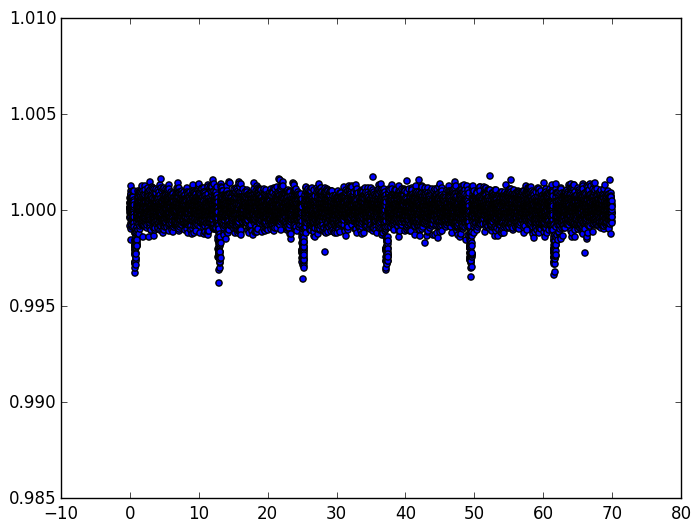

PyObject <matplotlib.collections.PathCollection object at 0x320de64d0>

In [6]:
scatter(time,flux/mean(flux))
#xlim(0,10)
#ylim(0.994,1.001)

In [7]:
function Period(time, rv)
    num = 3000
    periods = linspace(0.0, 15.0, num)
    chisq = ones(num)
    for i in range(1, num)
        mods = mod(time, periods[i])
        ind = sortperm(mods)
        newrv = rv[ind]
        sum = 0.0
        for k in range(1,length(time)-1)
            sum += (newrv[k+1]-newrv[k])^2.
        end
        chisq[i] = sum
    end
    #scatter(periods,chisq)
    #yscale("log")
    #xlim(0,100)
    return periods[indmin(chisq)] 
end

Period (generic function with 1 method)

In [8]:
function CircleOverlap(d, r1, r2)
    r = min(r1, r2)
    R = max(r1, r2)
    if d >= (r + R)
        return 0.0
    end
    if d <= (R-r)
        return pi*r^2
    end

    root_term = 0.5*sqrt((-d+r+R)*(d+r-R)*(d-r+R)*(d+r+R))
    r_term = r^2*acos((d^2 + r^2 - R^2)/(2.0*d*r))
    R_term = R^2*acos((d^2 + R^2 - r^2)/(2.0*d*R))
    return r_term + R_term - root_term
end


CircleOverlap (generic function with 1 method)

In [9]:
#p[b, P, rho, k, t_off]
#p[1] = b impact parameter
#p[2] = P period
#p[3] = rho stellar density
#p[4] = k r_planet/r_star
#p[5] = t_off timing offset before first ingress

function transit(t, p)
    G = 6.67259E-8 #cm^3 g^-1 cm^-2
    b = p[1]
    P = p[2]
    rho = p[3]
    k = p[4]
    t_off = p[5]
    v = (8.0 * pi^2.0 * G * rho / (3.0 * P*24.0*3600.0))^(1.0/3.0) *3600.*24.
    #T = (3.0 / pi^2.0)^(1.0/3.0) * sqrt(1.0-b^2.0) * (P/(2.0*pi))^(1.0/3.0) * (G*rho)^(-1.0/3.0)
    
    #Define array for the distance between the center of the planet and center of star at each time in t
    d = zeros(length(t))
    flux = ones(length(t))
    
    #Check for testing parameters ouside of allowed values which are:
    # 0 =< b < 1
    # 0.01 < k < 0.07
    # 0 < rho < 5 just to give some limit on the bounds of stellar density should be ~ 1
    if b > 1.0 
        return Inf
        elseif b < 0.0
        return Inf
    end
    if k >= 0.7 
        return Inf
        elseif k <= 0.0
        return Inf
    end
    if rho <= 0.0 
        return Inf
        elseif rho > 5
        return Inf
    end
    
    x_init = -(sqrt(1.0-b^2.0)+k)
    d[1] = sqrt(x_init^2.0+b^2.0)
    for i in range(2, length(t)-1)
        if t[i] < t_off
            flux[i] = 1.0
        else
            #del_t = (t[i] - t_off)
            del_t = mod((t[i]-t_off),P)
            #println(del_t)
            d[i] = sqrt((x_init+del_t*v)^2.0+b^2.0)
            #println(d[i])
            flux[i] = 1.0 - CircleOverlap(d[i], k, 1.0)/pi
        end
    end
    return flux
end

transit (generic function with 1 method)

In [10]:
index = zeros(length(time))
for i in range(1,length(time))
    if time[i] < 2.0
        index[i] = i
    else
        index[i] = 0
    end
end

transit_bottom_index = maximum(index)
j = round(Int,transit_bottom_index)
t_off_guess = 0.0
for i in range(1, j)
    if flux[i] == minimum(flux[1:j])
        t_off_guess = time[i]
    end
end
per_guess = Period(time,flux)
println("Guess for timing offset = ", t_off_guess)
println("Guess for period = ", per_guess)

Guess for timing offset = 0.

In [11]:
#test = [0.0, per_guess, 1.0, 0.05, t_off_guess]
#F = transit(time, test);

In [12]:
errors = 1.0 ./ (err ./ mean(flux)).^2.0

10000-element Array{Float64,1}:
 3.99946e6
 3.99946e6
 3.99946e6
 3.99946e6
 3.99946e6
 3.99946e6
 3.99946e6
 3.99946e6
 3.99946e6
 3.99946e6
 3.99946e6
 3.99946e6
 3.99946e6
 ⋮        
 3.99946e6
 3.99946e6
 3.99946e6
 3.99946e6
 3.99946e6
 3.99946e6
 3.99946e6
 3.99946e6
 3.99946e6
 3.99946e6
 3.99946e6
 3.99946e6

In [13]:
#p[b, P, rho, k, t_off]
test = [0.5, per_guess, 1.0, 0.061, t_off_guess]
fit = curve_fit(transit, time, flux/mean(flux), errors, test)
tfit = transit(time, fit.param);

In [17]:
#Fit parameters 
println("Impact parameter b = ", fit.param[1])
println("Period P = ", fit.param[2])
println("Stellar density rho = ", fit.param[3])
println("Relative planet radius k = ", fit.param[4])
println("Time until first transit = ", fit.param[5])

Impact parameter b = 0.6424783489015361
Period P = 12.16469405028183
Stellar density rho = 0.09027470667950138
Relative planet radius k = 0.04567394951647528
Time until first transit = 0.6578518712793957


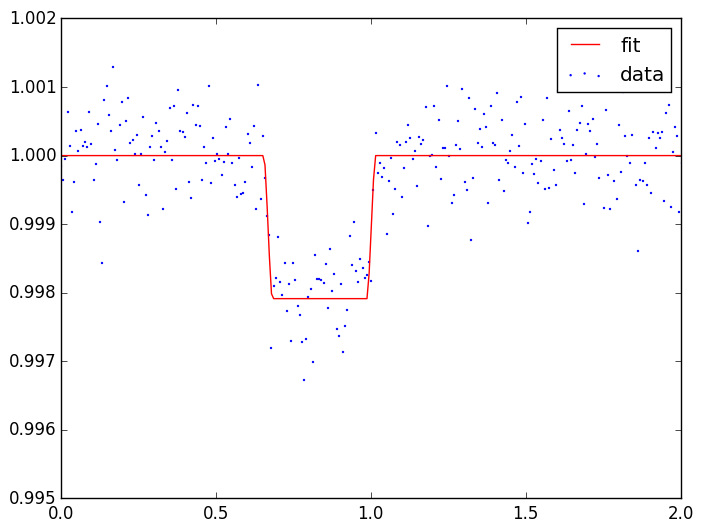

PyObject <matplotlib.legend.Legend object at 0x321a28910>

In [16]:
scatter(time, flux/mean(flux), color = "b", label = "data", s=0.5)
plot(time, tfit, color = "r", label = "fit")
ylim(0.995, 1.002)
#xlim(0,2)
legend()